In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

import AnomalyCLIP_lib
import torch
import argparse
import torch.nn.functional as F
from prompt_ensemble import AnomalyCLIP_PromptLearner
from loss import FocalLoss, BinaryDiceLoss
from utils import normalize
from dataset import Dataset
from logger import get_logger
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

import os
import random
import numpy as np
from tabulate import tabulate
from utils import get_transform

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

from visualization import visualizer

from metrics import image_level_metrics, pixel_level_metrics, image_level_threshold
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
torch.cuda.device_count()

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "2"  # Set the GPU 2 to use

# 1. Cal - Train split

In [4]:
parser = argparse.ArgumentParser("AnomalyCLIP", add_help=True)
# paths
parser.add_argument("--train_data_path", type=str, default="./data/mvtec", help="path to test dataset")
parser.add_argument("--data_path", type=str, default="./data/mvtec", help="path to test dataset")

parser.add_argument("--save_path", type=str, default='./results/1017_mvtec_15', help='path to save results')
parser.add_argument("--checkpoint_path", type=str, default='./train_results/1017_mvtec_15/epoch_15.pth', help='path to checkpoint')

# model
parser.add_argument("--dataset", type=str, default='mvtec')
parser.add_argument("--image_size", type=int, default=518, help="image size")
parser.add_argument("--depth", type=int, default=9, help="image size")
parser.add_argument("--n_ctx", type=int, default=12, help="zero shot")
parser.add_argument("--t_n_ctx", type=int, default=4, help="zero shot")
parser.add_argument("--feature_map_layer", type=int,  nargs="+", default=[0, 1, 2, 3], help="zero shot")
parser.add_argument("--features_list", type=int, nargs="+", default=[6, 12, 18, 24], help="features used")

parser.add_argument("--epoch", type=int, default=15, help="epoch")
parser.add_argument("--learning_rate", type=int, default=0.001, help="learning_rate")
parser.add_argument("--batch_size", type=int, default=8, help="batch_size")
parser.add_argument("--print_freq", type=int, default=1, help="print_freq")
parser.add_argument("--save_freq", type=int, default=15, help="save_freq")

parser.add_argument("--seed", type=int, default=111, help="random seed")
parser.add_argument("--sigma", type=int, default=4, help="zero shot")

parser.add_argument("--time", type=int, default=15, help="몇번째 실험인지")

args = parser.parse_args(args=[])

In [5]:
preprocess, target_transform = get_transform(args)
train_dataS = Dataset(root=args.data_path, transform=preprocess, target_transform=target_transform, dataset_name = args.dataset, mode='train')
print('전체 데이터 수 :', len(train_dataS))

generator1 = torch.Generator().manual_seed(args.time)
train_data, calibration_data = torch.utils.data.random_split(train_dataS, [0.5, 0.5], generator = generator1)
print(f'train_data: {len(train_data)} \ncalibration_data: {len(calibration_data)}')

 
 ********************** train ********************** 

전체 데이터 수 : 807
train_data: 404 
calibration_data: 403


In [6]:
logger = get_logger(args.save_path)

preprocess, target_transform = get_transform(args)


AnomalyCLIP_parameters = {"Prompt_length": args.n_ctx, "learnabel_text_embedding_depth": args.depth, "learnabel_text_embedding_length": args.t_n_ctx}


# 2. Model Train

In [7]:
# logger = get_logger(args.save_path)

# preprocess, target_transform = get_transform(args)


# AnomalyCLIP_parameters = {"Prompt_length": args.n_ctx, "learnabel_text_embedding_depth": args.depth, "learnabel_text_embedding_length": args.t_n_ctx}

# model, _ = AnomalyCLIP_lib.load("ViT-L/14@336px", device=device, design_details = AnomalyCLIP_parameters)
# model.eval()

# # train_data = Dataset(root=args.train_data_path, transform=preprocess, target_transform=target_transform, dataset_name = args.dataset, mode='train')
# train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=args.batch_size, shuffle=True)

# ##########################################################################################
# prompt_learner = AnomalyCLIP_PromptLearner(model.to("cpu"), AnomalyCLIP_parameters)
# prompt_learner.to(device)
# model.to(device)
# model.visual.DAPM_replace(DPAM_layer = 20)
# ##########################################################################################
# optimizer = torch.optim.Adam(list(prompt_learner.parameters()), lr=args.learning_rate, betas=(0.5, 0.999))

# # losses
# loss_focal = FocalLoss()
# loss_dice = BinaryDiceLoss()

# model.eval()
# prompt_learner.train()
# for epoch in tqdm(range(args.epoch)):
#     model.eval()
#     prompt_learner.train()
#     loss_list = []
#     image_loss_list = []

#     for items in tqdm(train_dataloader):
#         image = items['img'].to(device)
#         label =  items['anomaly']

#         gt = items['img_mask'].squeeze().to(device)
#         gt[gt > 0.5] = 1
#         gt[gt <= 0.5] = 0

#         with torch.no_grad():
#             # Apply DPAM to the layer from 6 to 24
#             # DPAM_layer represents the number of layer refined by DPAM from top to bottom
#             # DPAM_layer = 1, no DPAM is used
#             # DPAM_layer = 20 as default
#             image_features, patch_features = model.encode_image(image, args.features_list, DPAM_layer = 20)
#             image_features = image_features / image_features.norm(dim=-1, keepdim=True)
                
#         ####################################
#         prompts, tokenized_prompts, compound_prompts_text = prompt_learner(cls_id = None)
#         text_features = model.encode_text_learn(prompts, tokenized_prompts, compound_prompts_text).float()
#         text_features = torch.stack(torch.chunk(text_features, dim = 0, chunks = 2), dim = 1)
#         text_features = text_features/text_features.norm(dim=-1, keepdim=True)
#         # Apply DPAM surgery
#         text_probs = image_features.unsqueeze(1) @ text_features.permute(0, 2, 1)
#         text_probs = text_probs[:, 0, ...]/0.07
#         image_loss = F.cross_entropy(text_probs.squeeze(), label.long().cuda())
#         image_loss_list.append(image_loss.item())
#         #########################################################################
#         similarity_map_list = []
#         # similarity_map_list.append(similarity_map)
#         for idx, patch_feature in enumerate(patch_features):
#             if idx >= args.feature_map_layer[0]:
#                 patch_feature = patch_feature/ patch_feature.norm(dim = -1, keepdim = True)
#                 similarity, _ = AnomalyCLIP_lib.compute_similarity(patch_feature, text_features[0])
#                 similarity_map = AnomalyCLIP_lib.get_similarity_map(similarity[:, 1:, :], args.image_size).permute(0, 3, 1, 2)
#                 similarity_map_list.append(similarity_map)

#         loss = 0
#         for i in range(len(similarity_map_list)):
#             loss += loss_focal(similarity_map_list[i], gt)
#             loss += loss_dice(similarity_map_list[i][:, 1, :, :], gt)
#             loss += loss_dice(similarity_map_list[i][:, 0, :, :], 1-gt)

#         optimizer.zero_grad()
#         (loss+image_loss).backward()
#         optimizer.step()
#         loss_list.append(loss.item())
#     # logs
#     if (epoch + 1) % args.print_freq == 0:
#         logger.info('epoch [{}/{}], loss:{:.4f}, image_loss:{:.4f}'.format(epoch + 1, args.epoch, np.mean(loss_list), np.mean(image_loss_list)))

#     # save model
#     if (epoch + 1) % args.save_freq == 0:
#         ckp_path = os.path.join(args.save_path, 'epoch_' + str(epoch + 1) + '.pth')
#         torch.save({"prompt_learner": prompt_learner.state_dict()}, ckp_path)


# # torch.cuda.empty_cache()

# 3. Get score

### (1) train data

In [8]:
model, _ = AnomalyCLIP_lib.load("ViT-L/14@336px", device=device, design_details = AnomalyCLIP_parameters)
model.eval()

preprocess, target_transform = get_transform(args)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False)
obj_list = train_dataS.obj_list
print(f'data size: {len(train_dataloader)} \nobj_list ===> {obj_list}\n')

train_results = {}

for obj in obj_list:
    train_results[obj] = {}
    train_results[obj]['gt_sp'] = []
    train_results[obj]['pr_sp'] = []
    # train_results[obj]['pr_sp_n'] = []
    train_results[obj]['imgs_masks'] = []
    train_results[obj]['anomaly_maps'] = []


prompt_learner = AnomalyCLIP_PromptLearner(model.to("cpu"), AnomalyCLIP_parameters)
checkpoint = torch.load(args.checkpoint_path)
print(f'args.checkpoint_path ==> {args.checkpoint_path}')
prompt_learner.load_state_dict(checkpoint["prompt_learner"])
prompt_learner.to(device)
model.to(device)
model.visual.DAPM_replace(DPAM_layer = 20)

prompts, tokenized_prompts, compound_prompts_text = prompt_learner(cls_id = None)

text_features = model.encode_text_learn(prompts, tokenized_prompts, compound_prompts_text).float()
text_features = torch.stack(torch.chunk(text_features, dim = 0, chunks = 2), dim = 1)
text_features = text_features/text_features.norm(dim=-1, keepdim=True)
# print(text_features)

model.to(device)
features_list = args.features_list

for idx, items in enumerate(tqdm(train_dataloader)):
    
    image = items['img'].to(device)
    cls_name = items['cls_name']
    cls_id = items['cls_id']
    gt_mask = items['img_mask']
    gt_mask[gt_mask > 0.5], gt_mask[gt_mask <= 0.5] = 1, 0
    train_results[cls_name[0]]['imgs_masks'].append(gt_mask)  # px
    train_results[cls_name[0]]['gt_sp'].extend(items['anomaly'].detach().cpu())

    with torch.no_grad():
        image_features, patch_features = model.encode_image(image, features_list, DPAM_layer = 20)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        text_probs = image_features @ text_features.permute(0, 2, 1)
        text_probs = (text_probs/0.07).softmax(-1)
        text_probs_a = text_probs[:, 0, 1]
        text_probs_n = text_probs[:, 0, 0]
        anomaly_map_list = []
        for idx, patch_feature in enumerate(patch_features):
            if idx >= args.feature_map_layer[0]:
                patch_feature = patch_feature/ patch_feature.norm(dim = -1, keepdim = True)
                similarity, _ = AnomalyCLIP_lib.compute_similarity(patch_feature, text_features[0])
                similarity_map = AnomalyCLIP_lib.get_similarity_map(similarity[:, 1:, :], args.image_size)
                anomaly_map = (similarity_map[...,1] + 1 - similarity_map[...,0])/2.0
                anomaly_map_list.append(anomaly_map)

        anomaly_map = torch.stack(anomaly_map_list)
        
        anomaly_map = anomaly_map.sum(dim = 0)
        train_results[cls_name[0]]['pr_sp'].extend(text_probs_a.detach().cpu()) # image-abnormal
        # train_results[cls_name[0]]['pr_sp_n'].extend(text_probs_n.detach().cpu()) # image-normal
        anomaly_map = torch.stack([torch.from_numpy(gaussian_filter(i, sigma = args.sigma)) for i in anomaly_map.detach().cpu()], dim = 0 )
        train_results[cls_name[0]]['anomaly_maps'].append(anomaly_map)

torch.cuda.empty_cache()

name ViT-L/14@336px


text_layer False
text_layer True
data size: 404 
obj_list ===> ['carpet', 'wood', 'metal_nut', 'toothbrush']

embedding_pos torch.Size([1, 77, 768])
tokenized_prompts shape torch.Size([1, 1, 77]) torch.Size([1, 1, 77])
args.checkpoint_path ==> ./train_results/1017_mvtec_15/epoch_15.pth


100%|██████████| 404/404 [01:31<00:00,  4.41it/s]


### (2) calibration data

In [9]:
model, _ = AnomalyCLIP_lib.load("ViT-L/14@336px", device=device, design_details = AnomalyCLIP_parameters)
model.eval()

preprocess, target_transform = get_transform(args)
cali_dataloader = torch.utils.data.DataLoader(calibration_data, batch_size=1, shuffle=False)
obj_list = train_dataS.obj_list
print(f'data size: {len(cali_dataloader)} \nobj_list ===> {obj_list}\n')

cali_results = {}
cali_img_paths = []
for obj in obj_list:
    cali_results[obj] = {}
    cali_results[obj]['gt_sp'] = []
    cali_results[obj]['pr_sp'] = []
    # cali_results[obj]['pr_sp_n'] = []
    cali_results[obj]['imgs_masks'] = []
    cali_results[obj]['anomaly_maps'] = []


prompt_learner = AnomalyCLIP_PromptLearner(model.to("cpu"), AnomalyCLIP_parameters)
checkpoint = torch.load(args.checkpoint_path)
prompt_learner.load_state_dict(checkpoint["prompt_learner"])
prompt_learner.to(device)
model.to(device)
model.visual.DAPM_replace(DPAM_layer = 20)

prompts, tokenized_prompts, compound_prompts_text = prompt_learner(cls_id = None)

text_features = model.encode_text_learn(prompts, tokenized_prompts, compound_prompts_text).float()
text_features = torch.stack(torch.chunk(text_features, dim = 0, chunks = 2), dim = 1)
text_features = text_features/text_features.norm(dim=-1, keepdim=True)
# print(text_features)

model.to(device)
features_list = args.features_list

for idx, items in enumerate(tqdm(cali_dataloader)):
    cali_img_paths += items['img_path']
    image = items['img'].to(device)
    cls_name = items['cls_name']
    cls_id = items['cls_id']
    gt_mask = items['img_mask']
    gt_mask[gt_mask > 0.5], gt_mask[gt_mask <= 0.5] = 1, 0
    cali_results[cls_name[0]]['imgs_masks'].append(gt_mask)  # px
    cali_results[cls_name[0]]['gt_sp'].extend(items['anomaly'].detach().cpu())

    with torch.no_grad():
        image_features, patch_features = model.encode_image(image, features_list, DPAM_layer = 20)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        text_probs = image_features @ text_features.permute(0, 2, 1)
        text_probs = (text_probs/0.07).softmax(-1)
        text_probs_a = text_probs[:, 0, 1]
        text_probs_n = text_probs[:, 0, 0]
        anomaly_map_list = []
        for idx, patch_feature in enumerate(patch_features):
            if idx >= args.feature_map_layer[0]:
                patch_feature = patch_feature/ patch_feature.norm(dim = -1, keepdim = True)
                similarity, _ = AnomalyCLIP_lib.compute_similarity(patch_feature, text_features[0])
                similarity_map = AnomalyCLIP_lib.get_similarity_map(similarity[:, 1:, :], args.image_size)
                anomaly_map = (similarity_map[...,1] + 1 - similarity_map[...,0])/2.0
                anomaly_map_list.append(anomaly_map)

        anomaly_map = torch.stack(anomaly_map_list)
        
        anomaly_map = anomaly_map.sum(dim = 0)
        cali_results[cls_name[0]]['pr_sp'].extend(text_probs_a.detach().cpu()) # image-abnormal
        # cali_results[cls_name[0]]['pr_sp_n'].extend(text_probs_n.detach().cpu()) # image-normal
        anomaly_map = torch.stack([torch.from_numpy(gaussian_filter(i, sigma = args.sigma)) for i in anomaly_map.detach().cpu()], dim = 0 )
        cali_results[cls_name[0]]['anomaly_maps'].append(anomaly_map)

torch.cuda.empty_cache()

name ViT-L/14@336px
text_layer False
text_layer True
data size: 403 
obj_list ===> ['carpet', 'wood', 'metal_nut', 'toothbrush']

embedding_pos torch.Size([1, 77, 768])
tokenized_prompts shape torch.Size([1, 1, 77]) torch.Size([1, 1, 77])


100%|██████████| 403/403 [01:30<00:00,  4.45it/s]


In [10]:
with open(f"./1017test/{args.time}_cali_img_path.txt", 'w') as f:
    for path in cali_img_paths:
        f.write(path)
        f.write('\n')

### (3) test data

In [11]:
model, _ = AnomalyCLIP_lib.load("ViT-L/14@336px", device=device, design_details = AnomalyCLIP_parameters)
model.eval()

preprocess, target_transform = get_transform(args)
test_data = Dataset(root=args.data_path, transform=preprocess, target_transform=target_transform, dataset_name = args.dataset)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)
obj_list = test_data.obj_list
print(f'data size: {len(test_dataloader)} \nobj_list ===> {obj_list}\n')

test_results = {}
for obj in obj_list:
    test_results[obj] = {}
    test_results[obj]['gt_sp'] = []
    test_results[obj]['pr_sp'] = []
    # test_results[obj]['pr_sp_n'] = []
    test_results[obj]['imgs_masks'] = []
    test_results[obj]['anomaly_maps'] = []


prompt_learner = AnomalyCLIP_PromptLearner(model.to("cpu"), AnomalyCLIP_parameters)
checkpoint = torch.load(args.checkpoint_path)
prompt_learner.load_state_dict(checkpoint["prompt_learner"])
prompt_learner.to(device)
model.to(device)
model.visual.DAPM_replace(DPAM_layer = 20)

prompts, tokenized_prompts, compound_prompts_text = prompt_learner(cls_id = None)

text_features = model.encode_text_learn(prompts, tokenized_prompts, compound_prompts_text).float()
text_features = torch.stack(torch.chunk(text_features, dim = 0, chunks = 2), dim = 1)
text_features = text_features/text_features.norm(dim=-1, keepdim=True)
# print(text_features)

model.to(device)
features_list = args.features_list

for idx, items in enumerate(tqdm(test_dataloader)):
    
    image = items['img'].to(device)
    cls_name = items['cls_name']
    cls_id = items['cls_id']
    gt_mask = items['img_mask']
    gt_mask[gt_mask > 0.5], gt_mask[gt_mask <= 0.5] = 1, 0
    test_results[cls_name[0]]['imgs_masks'].append(gt_mask)  # px
    test_results[cls_name[0]]['gt_sp'].extend(items['anomaly'].detach().cpu())

    with torch.no_grad():
        image_features, patch_features = model.encode_image(image, features_list, DPAM_layer = 20)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        text_probs = image_features @ text_features.permute(0, 2, 1)
        text_probs = (text_probs/0.07).softmax(-1)
        text_probs_a = text_probs[:, 0, 1]
        text_probs_n = text_probs[:, 0, 0]
        anomaly_map_list = []
        for idx, patch_feature in enumerate(patch_features):
            if idx >= args.feature_map_layer[0]:
                patch_feature = patch_feature/ patch_feature.norm(dim = -1, keepdim = True)
                similarity, _ = AnomalyCLIP_lib.compute_similarity(patch_feature, text_features[0])
                similarity_map = AnomalyCLIP_lib.get_similarity_map(similarity[:, 1:, :], args.image_size)
                anomaly_map = (similarity_map[...,1] + 1 - similarity_map[...,0])/2.0
                anomaly_map_list.append(anomaly_map)

        anomaly_map = torch.stack(anomaly_map_list)
        
        anomaly_map = anomaly_map.sum(dim = 0)
        test_results[cls_name[0]]['pr_sp'].extend(text_probs_a.detach().cpu()) # image-abnormal
        # test_results[cls_name[0]]['pr_sp_n'].extend(text_probs_n.detach().cpu()) # image-normal
        anomaly_map = torch.stack([torch.from_numpy(gaussian_filter(i, sigma = args.sigma)) for i in anomaly_map.detach().cpu()], dim = 0 )
        test_results[cls_name[0]]['anomaly_maps'].append(anomaly_map)

torch.cuda.empty_cache()

name ViT-L/14@336px
text_layer False
text_layer True
 
 ********************** test ********************** 

data size: 353 
obj_list ===> ['carpet', 'wood', 'metal_nut', 'toothbrush']

embedding_pos torch.Size([1, 77, 768])
tokenized_prompts shape torch.Size([1, 1, 77]) torch.Size([1, 1, 77])


100%|██████████| 353/353 [01:20<00:00,  4.41it/s]


# 4. score plot

In [12]:
train_scores = []
test_scores = []
cal_scores = []
y_true = []

for obj in obj_list:
    train_scores += (train_results[obj]['pr_sp'])
    test_scores += (test_results[obj]['pr_sp'] )
    cal_scores += (cali_results[obj]['pr_sp'] )
    y_true += (test_results[obj]['gt_sp'])
    

datset_info = pd.DataFrame({'normal': [len(train_scores), len(test_scores)-y_true.count(1), len(cal_scores)], 'abnormal': [0, y_true.count(1), 0]}, index=['train', 'test', 'calibration'])
print(datset_info)
# print(f'train_size: {len(tain_scores)} \ntest_size: {len(test_scores)} \ncali_size: {len(cal_scores)}')


             normal  abnormal
train           404         0
test             81       272
calibration     403         0


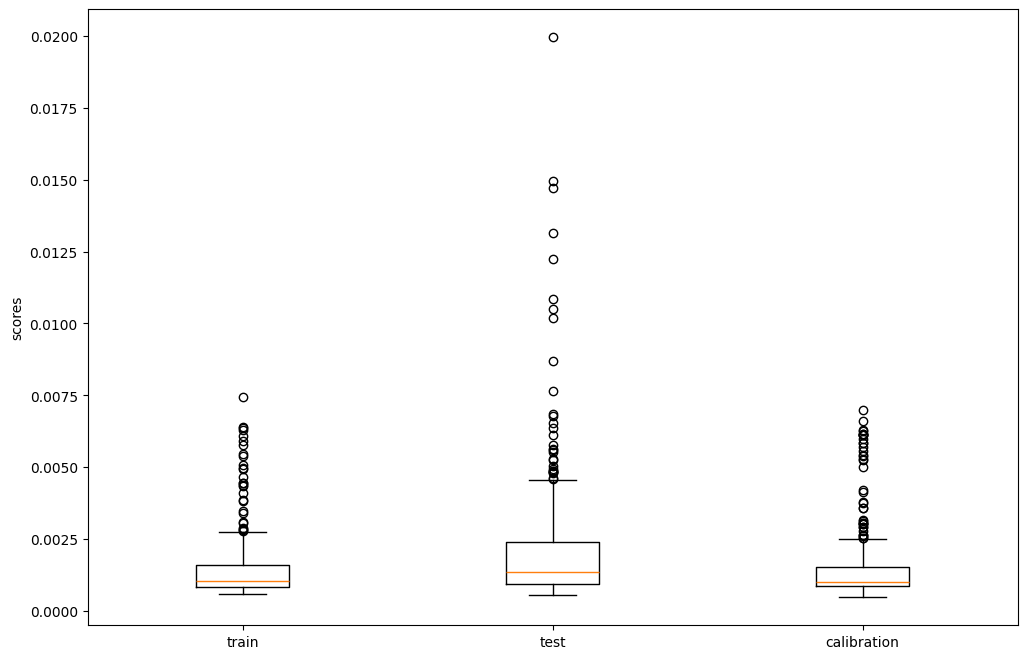

In [13]:
plt.figure(figsize=(12, 8))
plt.boxplot([train_scores, test_scores, cal_scores])
plt.xticks([1, 2, 3], ['train',  'test', 'calibration'])
plt.ylabel('scores')

plt.savefig(f'./1017test/{args.time}_score_box_plots.png')

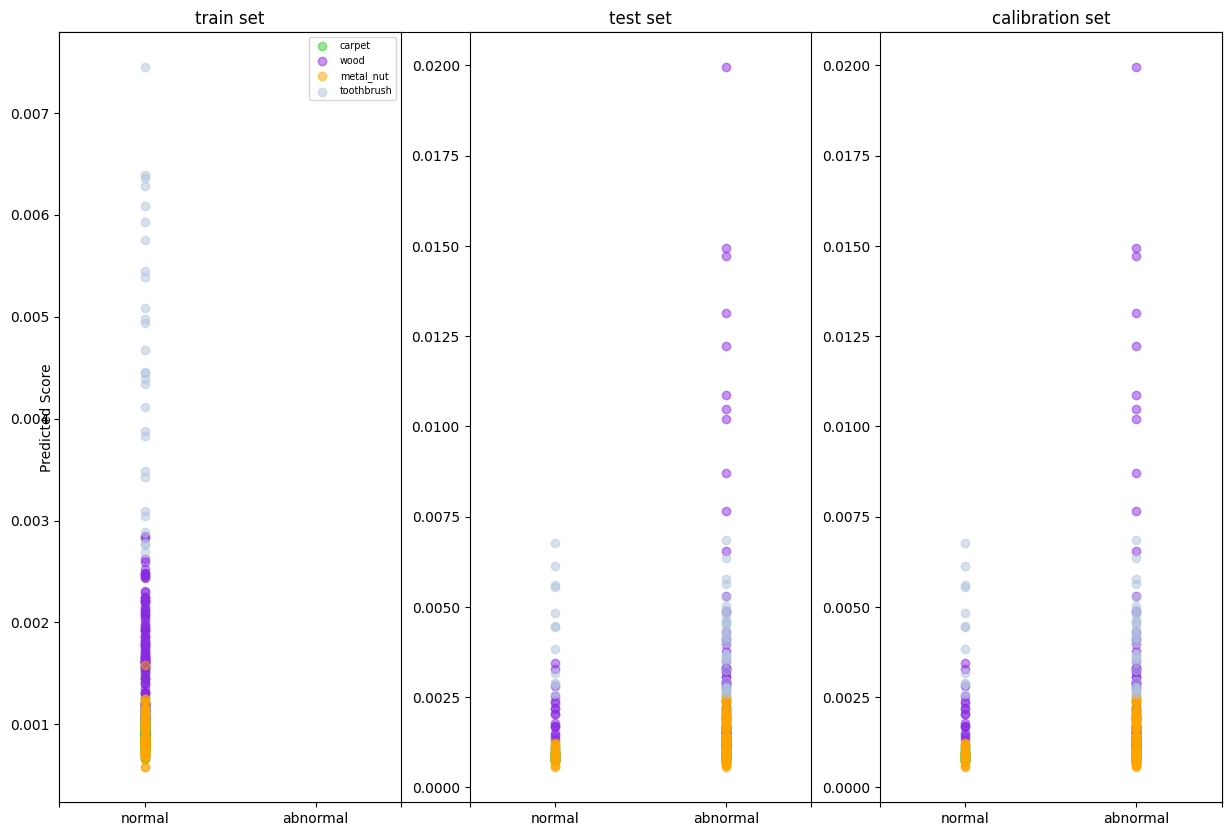

In [14]:
color_list = ['limegreen', 'blueviolet', 'orange', 'lightsteelblue']

plt.figure(figsize=(15, 10))
plt.ylabel('Predicted Score')
plt.xticks([])
plt.yticks([])
plt.subplot(1, 3, 1)

for idx, obj in enumerate(obj_list):
    plt.scatter(train_results[obj]['gt_sp'], train_results[obj]['pr_sp'], color=color_list[idx], label=obj, alpha=0.5)
plt.legend(fontsize='x-small', bbox_to_anchor=(1.0, 1.0))
plt.xticks([-0.5, 0, 1, 1.5], labels=['', 'normal', 'abnormal', ''])
plt.title('train set')


plt.subplot(1, 3, 2)
for idx, obj in enumerate(obj_list):
    plt.scatter(test_results[obj]['gt_sp'], test_results[obj]['pr_sp'], color=color_list[idx], label=obj, alpha=0.5)
# plt.legend(fontsize='x-small', bbox_to_anchor=(1.0, 1.0))
plt.xticks([-0.5, 0, 1, 1.5], labels=['', 'normal', 'abnormal', ''])
plt.title('test set')


plt.subplot(1, 3, 3)
for idx, obj in enumerate(obj_list):
    plt.scatter(test_results[obj]['gt_sp'], test_results[obj]['pr_sp'], color=color_list[idx], label=obj, alpha=0.5)
# plt.legend(fontsize='x-small', bbox_to_anchor=(1.0, 1.0))
plt.xticks([-0.5, 0, 1, 1.5], labels=['', 'normal', 'abnormal', ''])
plt.title('calibration set')


plt.savefig(f'./1017test/{args.time}_score_scatter_plots.png')

# 5. Train q_hat

In [15]:
test_info = {}

In [16]:
n = len(train_scores)
alpha = 0.1

q_level = np.ceil((n+1)*(1-alpha))/n 
train_qhat = np.quantile(train_scores, q_level, method='higher')

y_true = np.array(y_true)
test_scores = np.array(test_scores)
y_pred = (test_scores > train_qhat)

p = precision_score(y_true, y_pred)
r = recall_score(y_true, y_pred)

test_info['train_qhat'] = [train_qhat, round(p, 4), round(r, 4)]
print(f'train_qhat: {train_qhat} \nprecision: {round(p, 4)} \nrecall: {round(r, 4)}')

train_qhat: 0.002450120635330677 
precision: 0.8095 
recall: 0.25


# 6. Calibration q_hat

In [17]:
n = len(cal_scores)
alpha = 0.1

q_level = np.ceil((n+1)*(1-alpha))/n 
cali_qhat = np.quantile(cal_scores, q_level, method='higher')

# y_true = np.array(y_true)
# test_scores = np.array(test_scores)
y_pred = (test_scores > cali_qhat)

p = precision_score(y_true, y_pred)
r = recall_score(y_true, y_pred)

test_info['cal_qhat'] = [cali_qhat, round(p, 4), round(r, 4)]

print(f'cali_qhat: {cali_qhat} \nprecision: {round(p, 4)} \nrecall: {round(r, 4)}')

cali_qhat: 0.002540714805945754 
precision: 0.8171 
recall: 0.2463


# 7. conformal p-value

In [18]:
from cccpv.models import ToyModel
from cccpv.methods import ConformalPvalues
from cccpv.methods import calibrate_ccv

In [19]:
y_true_np = np.array([t.item() for t in y_true])

is_outlier = np.zeros(len(test_scores))
is_outlier[np.where(y_true_np == 1)[0]] = 1

scores_test = np.array(test_scores)
scores_cal = np.array(cal_scores)

scores_cal_mat = np.tile(scores_cal, (len(scores_test), 1))
pvals_numerator = np.sum(scores_cal_mat > scores_test.reshape(len(scores_test),1), 1) 
pvals_marginal = (1.0+pvals_numerator)/(1.0+len(scores_cal))

In [20]:
np.count_nonzero(is_outlier) # 이상치 개수

272

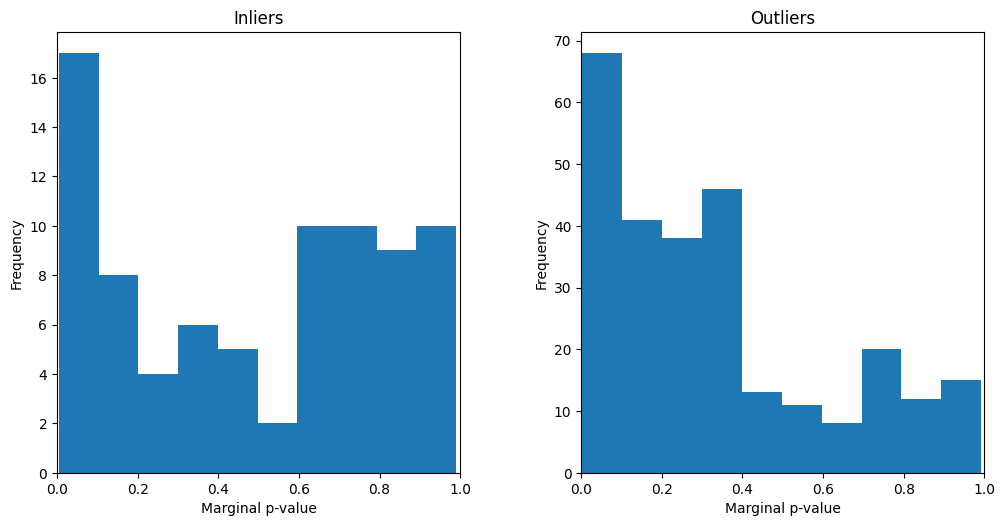

In [21]:
# Histogram of marginal p-values
fig, axs = plt.subplots(1,2, figsize=(10, 5))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

axs[0].hist(pvals_marginal[is_outlier == 0])
axs[0].set_xlabel("Marginal p-value")
axs[0].set_ylabel("Frequency")
axs[0].title.set_text('Inliers')
axs[0].set_xlim([0,1])

axs[1].hist(pvals_marginal[is_outlier==1])
axs[1].set_xlabel("Marginal p-value")
axs[1].set_ylabel("Frequency")
axs[1].title.set_text('Outliers')
axs[1].set_xlim([0, 1]) 

plt.savefig(f'./1017test/{args.time}_marginal_histogram.png', bbox_inches='tight')

In [22]:
pred_pvals_marginal = pvals_marginal<0.05

p = precision_score(y_true_np, pred_pvals_marginal, zero_division=0)

r = recall_score(y_true_np, pred_pvals_marginal, zero_division=0)

test_info['marginal_pvalue'] = ['', round(p, 4), round(r, 4)]

print(f'precision: {round(p, 3)}\nrecall: {round(r, 3)}')

precision: 0.811
recall: 0.11


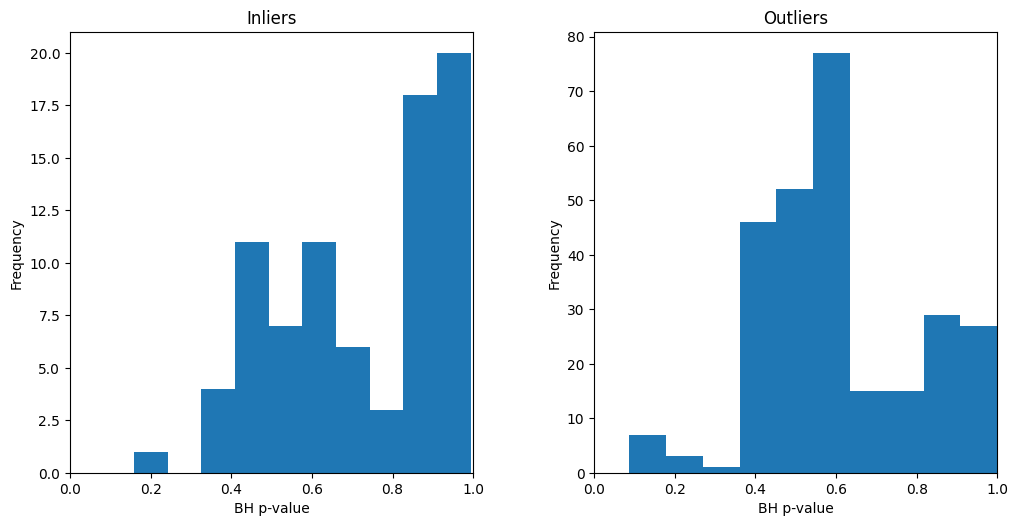

In [23]:
pvals_marginal_sorted = np.sort(pvals_marginal)
m = len(pvals_marginal)

pvals_marginal_bh = np.minimum(1, pvals_marginal_sorted * (m / np.arange(1, m + 1)))

pvals_marginal_bh_full = np.empty_like(pvals_marginal)
pvals_marginal_bh_full[np.argsort(pvals_marginal)] = pvals_marginal_bh

# Histogram of marginal p-values
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

axs[0].hist(pvals_marginal_bh_full[is_outlier==0])
axs[0].set_xlabel("BH p-value")
axs[0].set_ylabel("Frequency")
axs[0].title.set_text('Inliers')
axs[0].set_xlim([0,1])

axs[1].hist(pvals_marginal_bh_full[is_outlier==1])
axs[1].set_xlabel("BH p-value")
axs[1].set_ylabel("Frequency")
axs[1].title.set_text('Outliers')
axs[1].set_xlim([0,1])

plt.savefig(f'./1017test/{args.time}_bh_histogram.png', bbox_inches='tight')

In [24]:
pred_marginal_bh_full = pvals_marginal_bh_full<0.05

p = precision_score(y_true_np, pred_marginal_bh_full, zero_division=0)

r = recall_score(y_true_np, pred_marginal_bh_full, zero_division=0)

test_info['bh_pvalue'] = ['', round(p, 4), round(r, 4)]
print(f'precision: {round(p, 3)}\nrecall: {round(r, 3)}')

precision: 0.0
recall: 0.0


In [25]:
test_info_df = pd.DataFrame(test_info, index=['q_hat', 'precision', 'recall'])

In [26]:
datset_info.to_csv(f'./1017test/{args.time}_datset_info.csv')
test_info_df.to_csv(f'./1017test/{args.time}_test_info.csv')

In [33]:
from statsmodels.stats import multitest 

y_pred, pvals_bh = multitest.fdrcorrection(pvals_marginal, alpha=0.05, method='indep', is_sorted=False)

In [39]:
len(np.where(y_pred==True))

1

In [42]:
len(np.where(y_pred==False))

1

In [44]:
numeric_array = y_pred.astype(int)
numeric_array

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

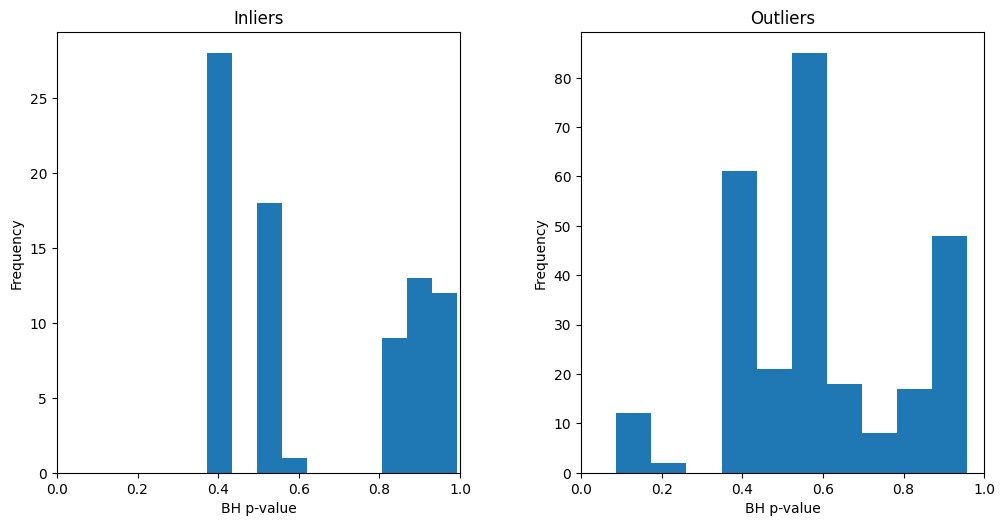

In [35]:
# Histogram of marginal p-values
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

axs[0].hist(pvals_bh[is_outlier==0])
axs[0].set_xlabel("BH p-value")
axs[0].set_ylabel("Frequency")
axs[0].title.set_text('Inliers')
axs[0].set_xlim([0,1])

axs[1].hist(pvals_bh[is_outlier==1])
axs[1].set_xlabel("BH p-value")
axs[1].set_ylabel("Frequency")
axs[1].title.set_text('Outliers')
axs[1].set_xlim([0,1])

plt.savefig(f'./1017test/{args.time}_bh_histogram.png', bbox_inches='tight')

In [36]:
p = precision_score(is_outlier, y_pred, zero_division=0)

r = recall_score(is_outlier, y_pred, zero_division=0)

test_info['bh_pvalue'] = ['', round(p, 4), round(r, 4)]
print(f'precision: {round(p, 3)}\nrecall: {round(r, 3)}')

precision: 0.0
recall: 0.0
